In [16]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio
import cv2

import tensorflow as tf
import tensorflow.keras as keras
import keras.models as models
import keras.layers as layers
from keras.applications.efficientnet import EfficientNetB0

from data_processing import preprocess, visualize

In [46]:
# reload modules after making changes
import importlib
importlib.reload(preprocess)
importlib.reload(visualize)

<module 'data_processing.visualize' from 'C:\\Users\\Kelvin\\bloodcell-classification\\data_processing\\visualize.py'>

In [2]:
# set constants
TRAINING_IMAGES_DIR = 'data/images/TRAIN' # directory/path to training images
TEST_IMAGES_DIR = 'data/images/TEST' # directory/path to test images
TRAINING_LABELS_PATH = 'data/labels.csv' # path to training labels csv

# image size (required by EfficientNet)
IMAGE_HEIGHT = 224 # pixels
IMAGE_WIDTH = 224 # pixels

# dictionaries mapping each label to an integer representation (or vice versa)
REP_TO_LABELS = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}
LABELS_TO_REP = {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

## Data Loading

In [8]:
# construct tf.data.Datasets to hold our data:p
train_set, val_set = preprocess.load_images_dataset(TRAINING_IMAGES_DIR,
                                                     target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                     batch_size=10,
                                                     validation_split=0.2)

Found 9957 files belonging to 4 classes.
Using 7966 files for training.
Using 1991 files for validation.


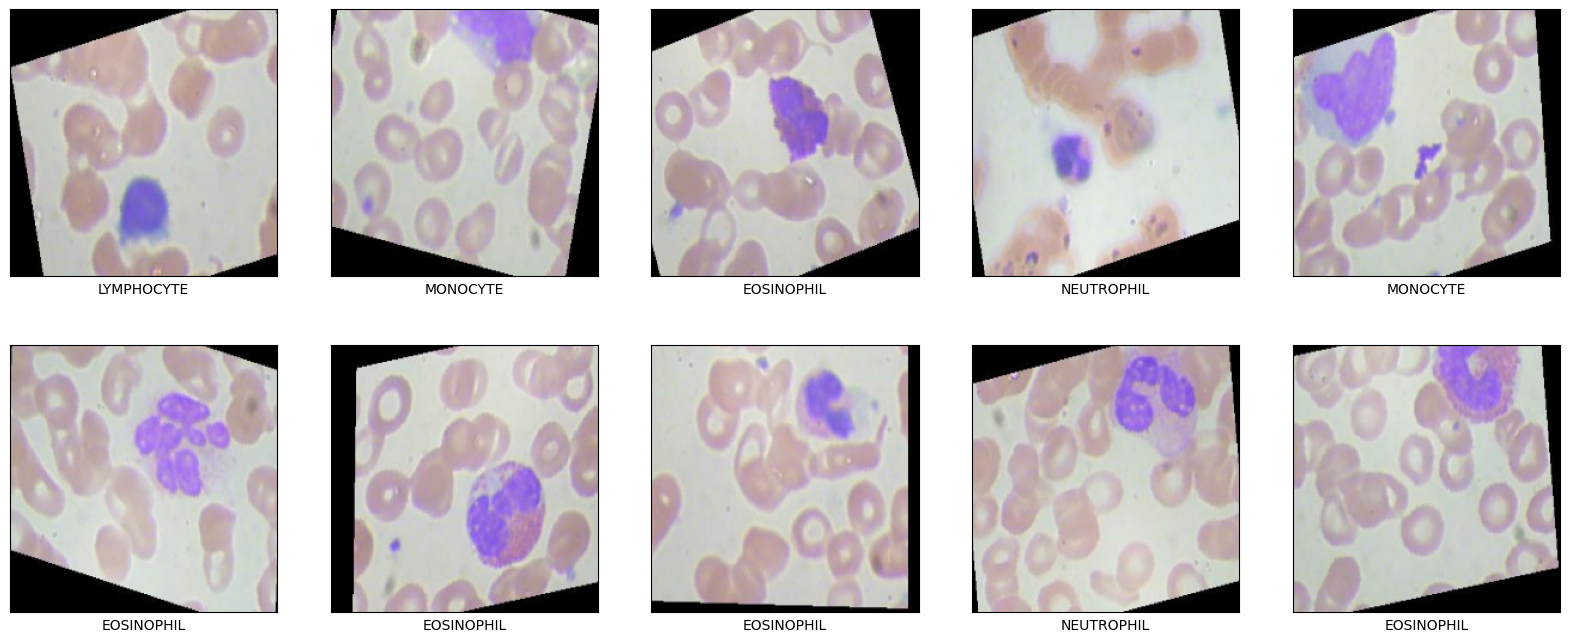

In [18]:
# visualize dataset
visualize.visualize_dataset(train_set, REP_TO_LABELS)

<BarContainer object of 4 artists>

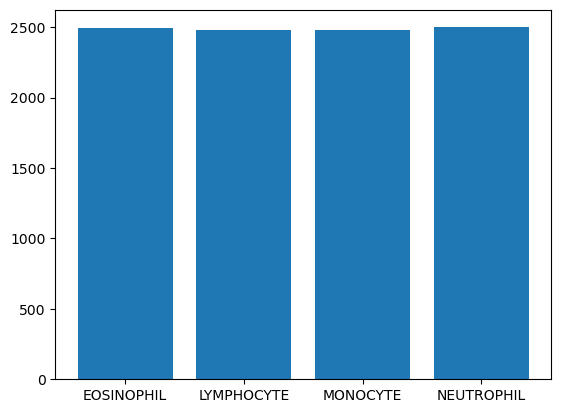

In [10]:
# histogram of labels
labels = pd.Series(train_labels)
plt.bar(REP_TO_LABELS.values(), height=labels.groupby(labels).size())

## Model 2: Transfer Learning with EfficientNet

In [ ]:
# load EfficientNet 
enet = EfficientNetB0(include_top=False, input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
enet.summary()

In [7]:
# freeze efficientnet layers
for layer in enet.layers:
    layer.trainable = False

# add final prediction layers
model_enet_tl = models.Sequential([enet, 
                                   layers.GlobalAveragePooling2D(),
                                   layers.BatchNormalization(),
                                   layers.Dropout(0.2),
                                   layers.Dense(4)])

model_enet_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 4,059,815
Trainable params: 7,684
Non-trai

In [10]:
# stop early if loss stops improvingv
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# compile model
model_enet_tl.compile(optimizer='adam',
                      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

# train prediction layers
history_enet_tl = model_enet_tl.fit(train_set,
                                    epochs=20,
                                    validation_data=val_set,
                                    callbacks=[early_stop])

Epoch 1/20
797/797 [==============================] - 34s 32ms/step - loss: 0.8592 - accuracy: 0.6582 - val_loss: 0.3814 - val_accuracy: 0.8619
Epoch 2/20
797/797 [==============================] - 24s 30ms/step - loss: 0.5739 - accuracy: 0.7714 - val_loss: 0.2706 - val_accuracy: 0.9001
Epoch 3/20
797/797 [==============================] - 24s 30ms/step - loss: 0.5314 - accuracy: 0.7927 - val_loss: 0.2555 - val_accuracy: 0.9046
Epoch 4/20
797/797 [==============================] - 24s 30ms/step - loss: 0.5173 - accuracy: 0.7985 - val_loss: 0.2354 - val_accuracy: 0.9086
Epoch 5/20
797/797 [==============================] - 24s 30ms/step - loss: 0.4928 - accuracy: 0.8083 - val_loss: 0.2297 - val_accuracy: 0.9106
Epoch 6/20
797/797 [==============================] - 24s 30ms/step - loss: 0.4936 - accuracy: 0.8108 - val_loss: 0.2136 - val_accuracy: 0.9191
Epoch 7/20
797/797 [==============================] - 24s 30ms/step - loss: 0.5130 - accuracy: 0.8043 - val_loss: 0.2189 - val_accuracy:

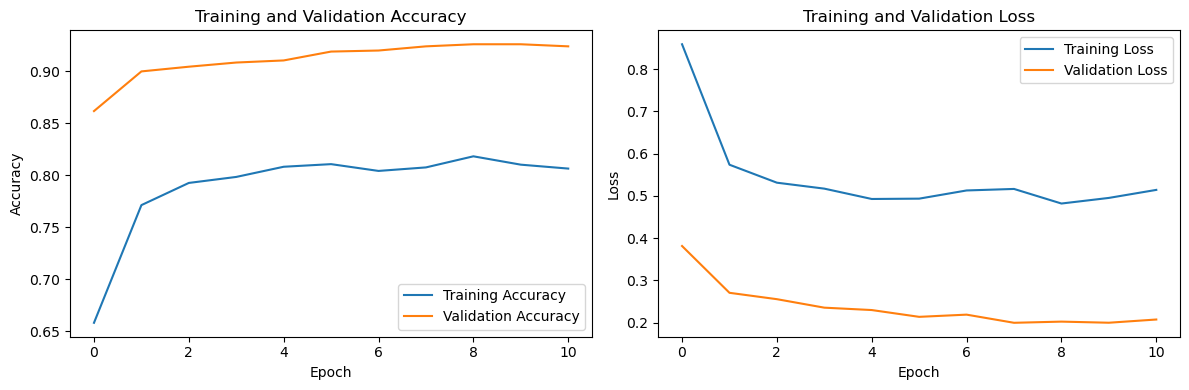

In [22]:
visualize.visualize_history(history_enet_tl)

In [12]:
# fine tuning:

# unfreeze top twenty layers except batchnormalization
for layer in model_enet_tl.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

# recompile model
model_enet_tl.compile(optimizer=keras.optimizers.Adam(1e-5),
                      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

# train
history_enet_tuned = model_enet_tl.fit(train_set,
                                       epochs=4,
                                       validation_data=val_set)

Epoch 1/4
797/797 [==============================] - 82s 90ms/step - loss: 1.6142 - accuracy: 0.5338 - val_loss: 0.5383 - val_accuracy: 0.8117
Epoch 2/4
797/797 [==============================] - 70s 88ms/step - loss: 0.7288 - accuracy: 0.7518 - val_loss: 0.2384 - val_accuracy: 0.9146
Epoch 3/4
797/797 [==============================] - 70s 88ms/step - loss: 0.4493 - accuracy: 0.8435 - val_loss: 0.1434 - val_accuracy: 0.9518
Epoch 4/4
797/797 [==============================] - 70s 88ms/step - loss: 0.3331 - accuracy: 0.8809 - val_loss: 0.0923 - val_accuracy: 0.9653


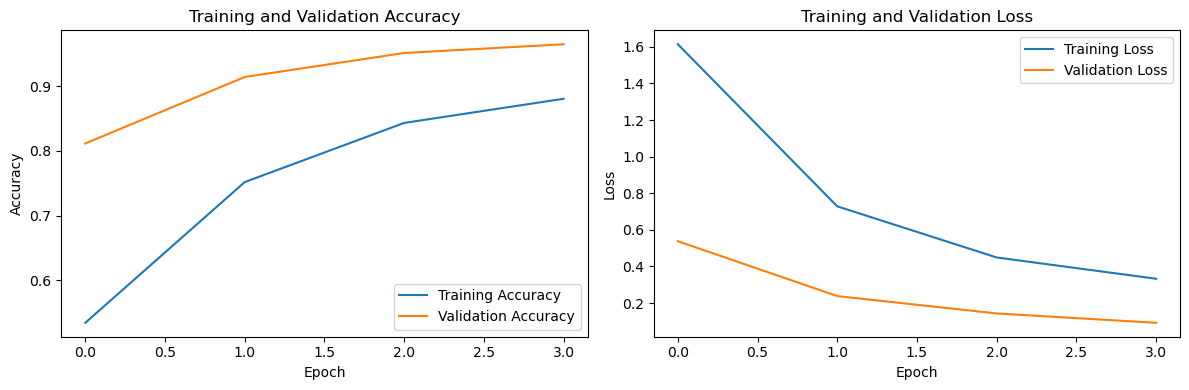

In [23]:
visualize.visualize_history(history_enet_tuned)

In [14]:
# save weights
model_enet_tl.save_weights("bloodcell-efficientnetb0_weights.h5")

In [28]:
# load test set
test_set = preprocess.load_images_dataset(TEST_IMAGES_DIR,
                                          target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                          batch_size=1)

# evaluate the model on the test set
test_loss, test_accuracy = model_enet_tl.evaluate(test_set)

print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

Found 2487 files belonging to 4 classes.
2487/2487 [==============================] - 31s 13ms/step - loss: 0.8287 - accuracy: 0.8343
Test accuracy: 0.8343385457992554
Test loss: 0.8286756873130798


1/1 [==============================] - 1s 1s/step


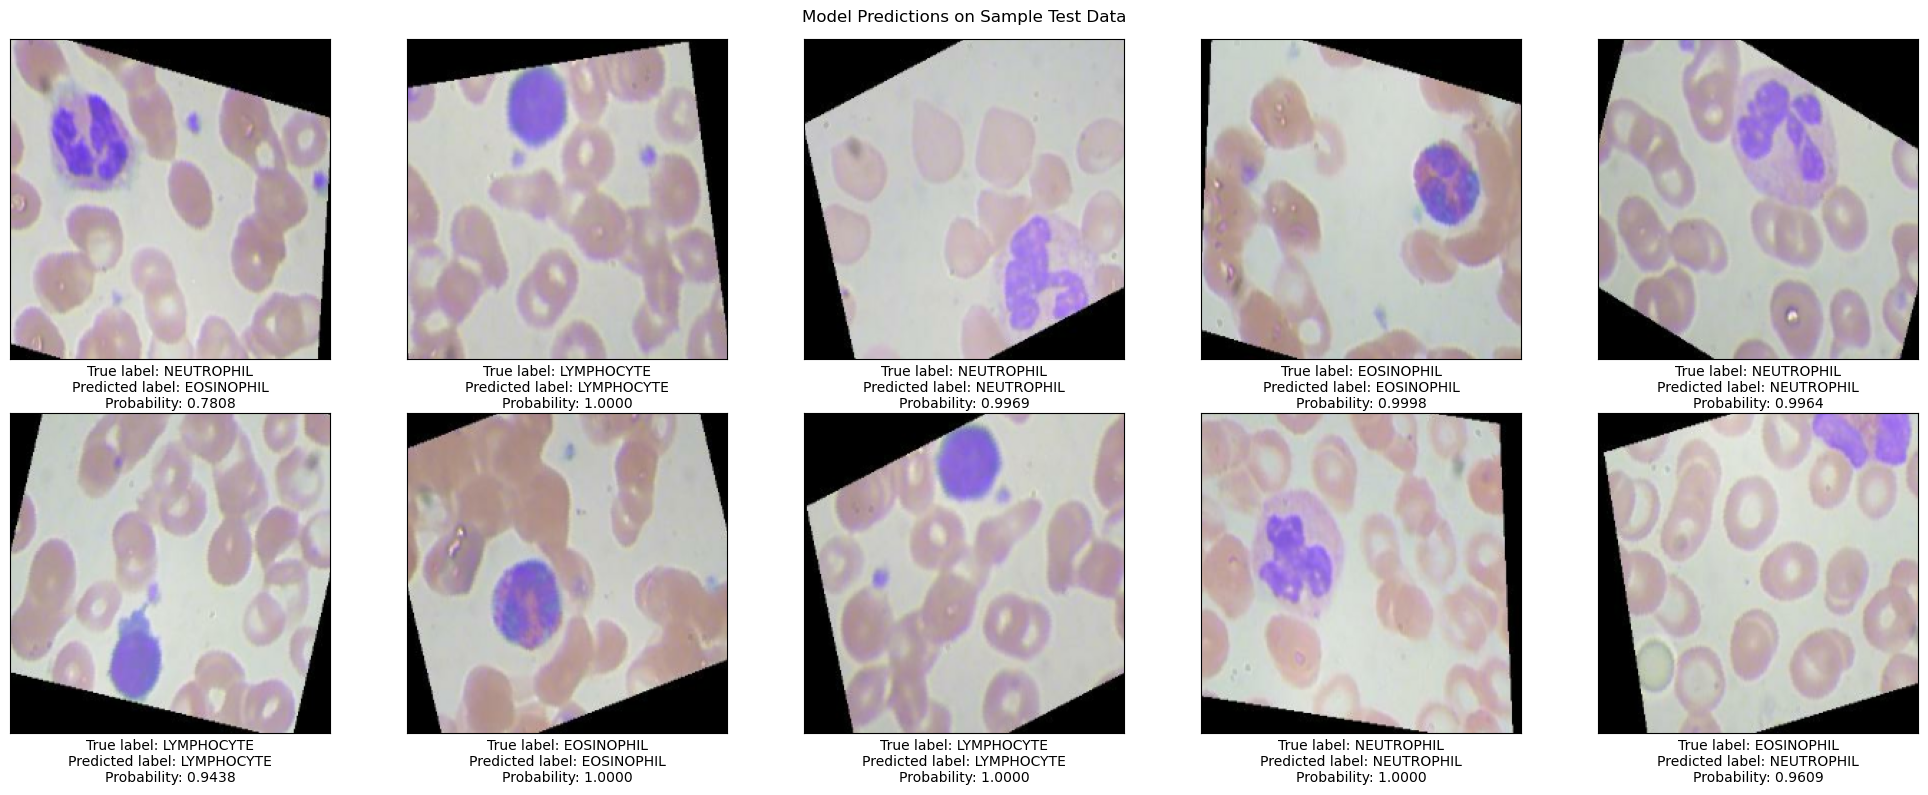

In [47]:
visualize.visualize_predictions(model_enet_tl, test_set, REP_TO_LABELS)